In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CTC-A.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,2573,-1738,835,76,576,853,1679,8002,0,...,1779,0,272,4191,2337,8118,-43,39,80.52,2014-05-10
1,2014-06-30,3166,-2153,1013,179,308,534,1555,7385,0,...,1706,0,319,4092,1841,7577,306,21,80.09,2014-08-09
2,2014-09-30,3070,-2085,985,178,410,845,1973,8251,0,...,2040,0,321,4542,2394,8591,-173,-261,79.21,2014-11-09
3,2014-12-31,3654,-2440,1214,207,662,880,1624,8510,0,...,1961,0,588,4579,2132,8922,-484,-388,78.46,2015-02-14
4,2015-03-31,2515,-1633,882,88,291,1105,1891,8452,0,...,1897,0,587,4434,2130,8869,-185,-75,77.90,2015-05-10


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-14,58.50,5340,-3322,2018,563,331,1310,3216,...,2342,22102,3201,0,1040,7147,3217,15063,911,-182
36,2023-03-31,2023-05-10,57.43,3707,-2425,1282,43,312,1508,3280,...,2288,22163,2849,0,985,7498,3218,15460,-311,-159
37,2023-06-30,2023-08-09,56.55,4256,-2807,1449,127,433,863,3214,...,2248,21840,2926,0,1545,7704,2659,15283,823,-74
38,2023-09-30,2023-11-09,55.76,4250,-2814,1436,-28,459,1524,3360,...,2256,22713,2990,0,561,6999,3754,16212,-29,-162
39,2023-12-31,2024-02-14,55.76,4443,-2906,1537,197,311,1151,2693,...,2255,21978,2689,0,561,6389,4404,15533,870,-353


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-14,58.50,5340,-3322,2018,563,331,1310,3216,...,22102,3201,0,1040,7147,3217,15063,911,-182,1.357405
36,2023-03-31,2023-05-10,57.43,3707,-2425,1282,43,312,1508,3280,...,22163,2849,0,985,7498,3218,15460,-311,-159,1.352063
37,2023-06-30,2023-08-09,56.55,4256,-2807,1449,127,433,863,3214,...,21840,2926,0,1545,7704,2659,15283,823,-74,1.343352
38,2023-09-30,2023-11-09,55.76,4250,-2814,1436,-28,459,1524,3360,...,22713,2990,0,561,6999,3754,16212,-29,-162,1.341033
39,2023-12-31,2024-02-14,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-14,58.50,5340,-3322,2018,563,331,1310,3216,...,22102,3201,0,1040,7147,3217,15063,911,-182,1.357405
36,2023-03-31,2023-05-10,57.43,3707,-2425,1282,43,312,1508,3280,...,22163,2849,0,985,7498,3218,15460,-311,-159,1.352063
37,2023-06-30,2023-08-09,56.55,4256,-2807,1449,127,433,863,3214,...,21840,2926,0,1545,7704,2659,15283,823,-74,1.343352
38,2023-09-30,2023-11-09,55.76,4250,-2814,1436,-28,459,1524,3360,...,22713,2990,0,561,6999,3754,16212,-29,-162,1.341033
39,2023-12-31,2024-02-14,55.76,4443,-2906,1537,197,311,1151,2693,...,21978,2689,0,561,6389,4404,15533,870,-353,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-12,80.996391,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.402517,0.597483,0.0,0.0,0.0,0.0,0.324524,0.029538,0.0,0.0
1,2014-05-19,78.514359,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.402517,0.597483,0.0,0.0,0.0,0.0,0.324524,0.029538,0.0,0.0
2,2014-05-26,79.387245,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.402517,0.597483,0.0,0.0,0.0,0.0,0.324524,0.029538,0.0,0.0
3,2014-06-02,79.926155,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.402517,0.597483,0.0,0.0,0.0,0.0,0.324524,0.029538,0.0,0.0
4,2014-06-09,78.157608,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.402517,0.597483,0.0,0.0,0.0,0.0,0.324524,0.029538,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-12,80.996391,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.0,0.324524,0.029538,0.0,0.0,inf,1.192509,0.633680,1.366482,inf
1,2014-05-19,78.514359,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.0,0.324524,0.029538,0.0,0.0,inf,1.155966,0.614261,1.347063,inf
2,2014-05-26,79.387245,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.0,0.324524,0.029538,0.0,0.0,inf,1.168817,0.621090,1.353892,inf
3,2014-06-02,79.926155,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.0,0.324524,0.029538,0.0,0.0,inf,1.176752,0.625306,1.358109,inf
4,2014-06-09,78.157608,2014-03-31,2573.0,0.0,67.921013,80.52,0.0,0.0,576.0,...,0.0,0.324524,0.029538,0.0,0.0,inf,1.150713,0.611470,1.344272,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

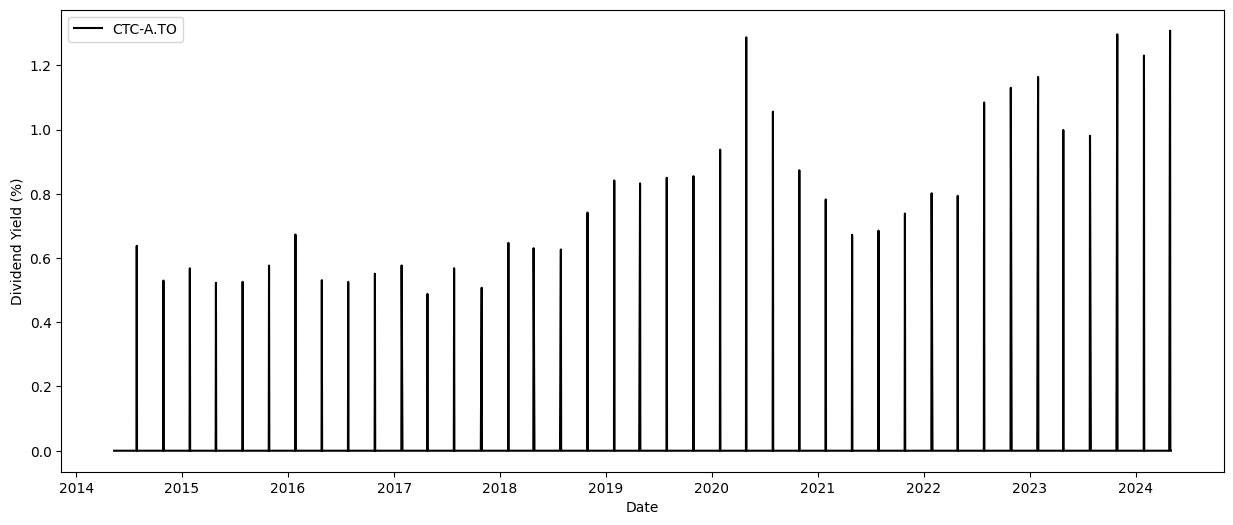

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.130534
share_price      1.000000
Name: share_price, dtype: float64


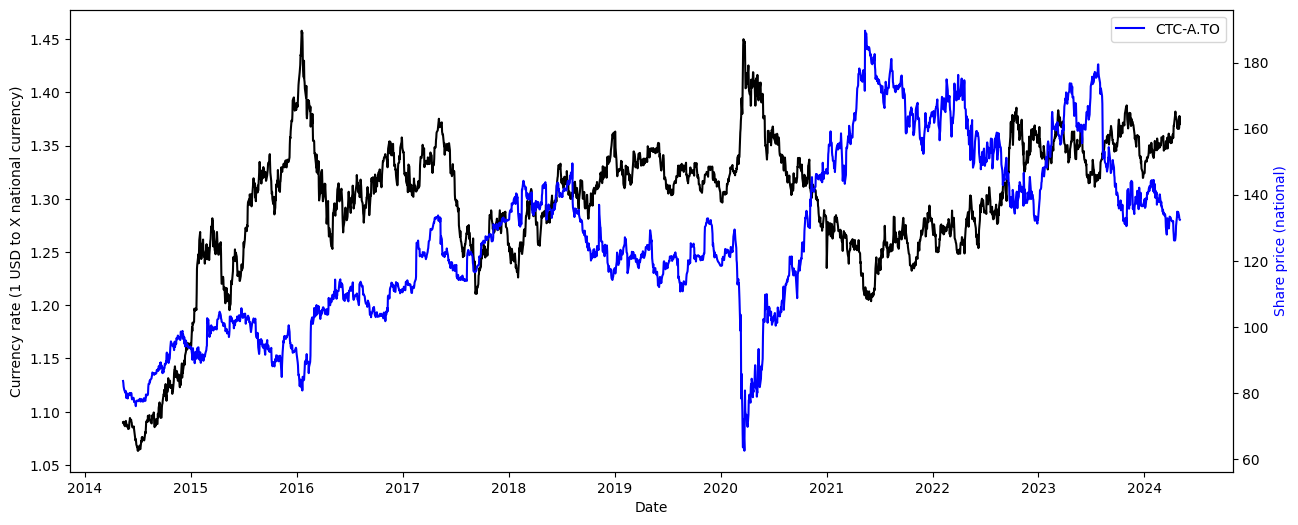

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

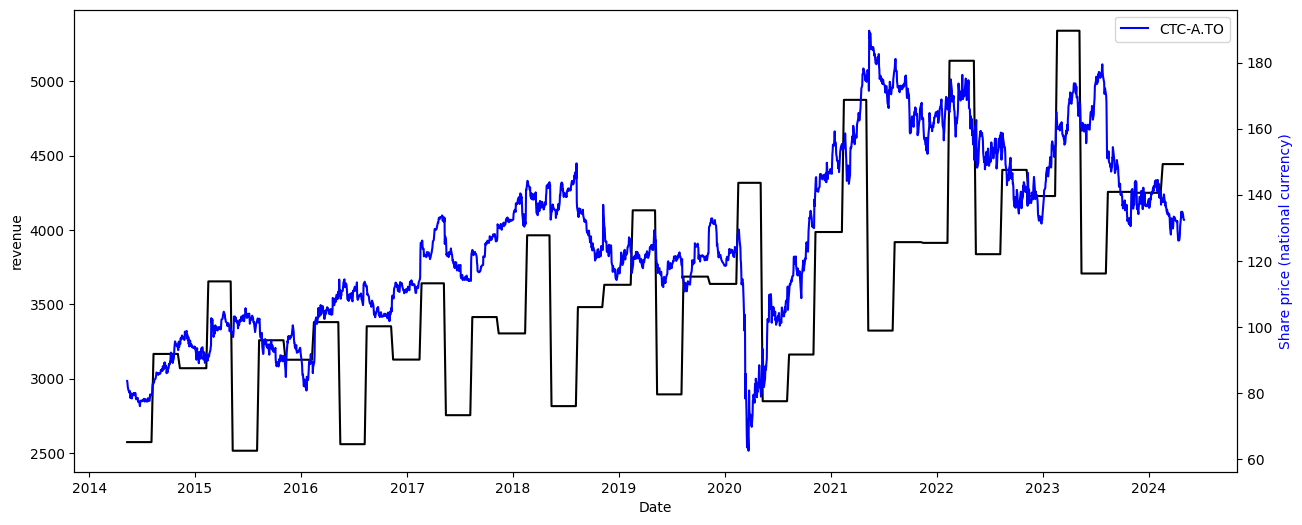

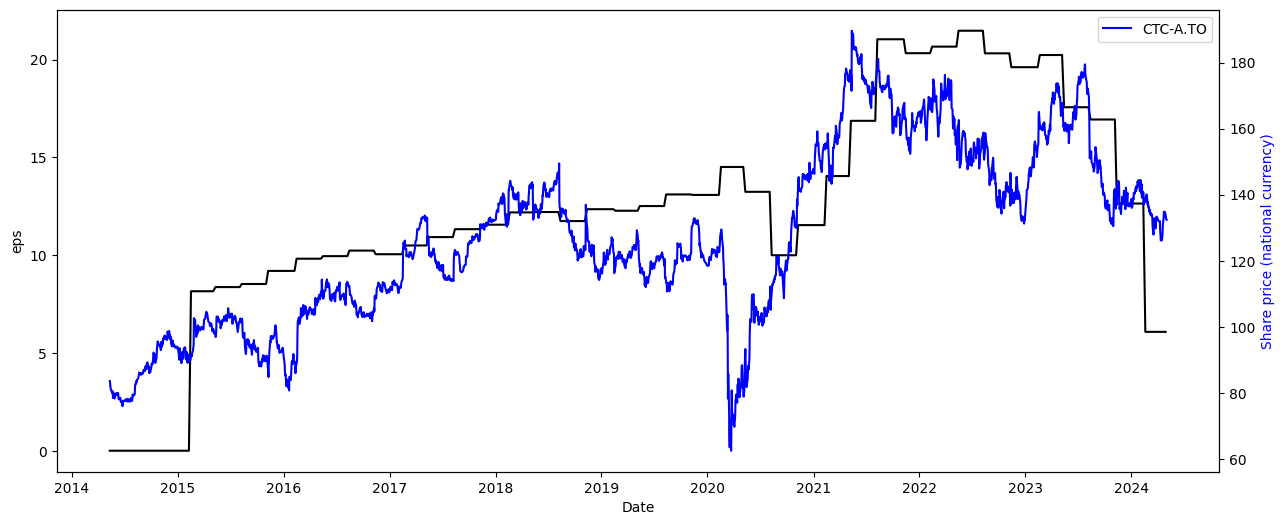

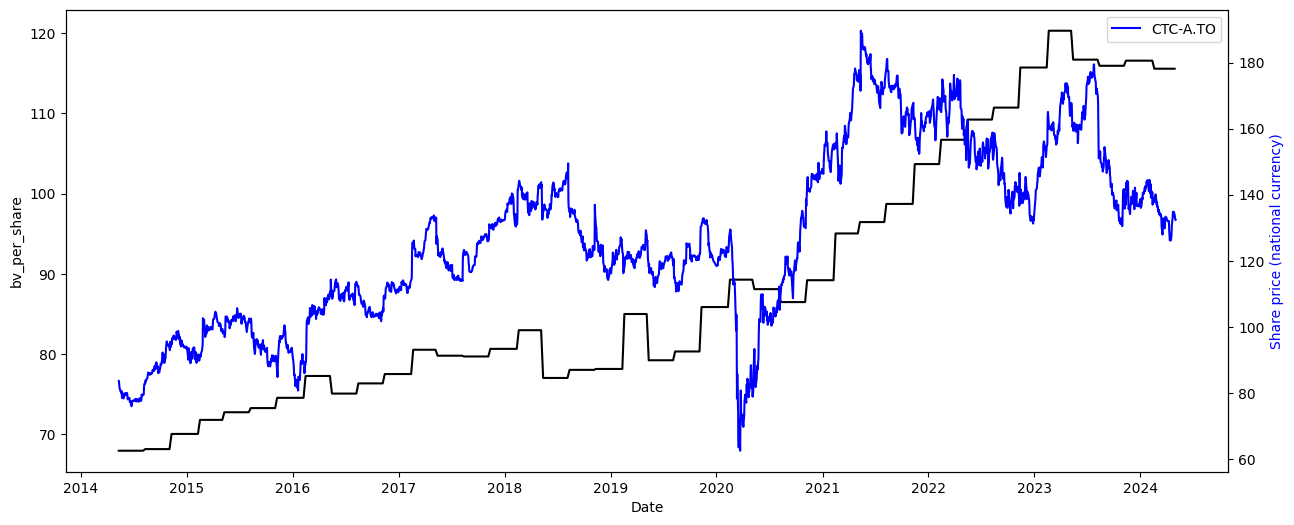

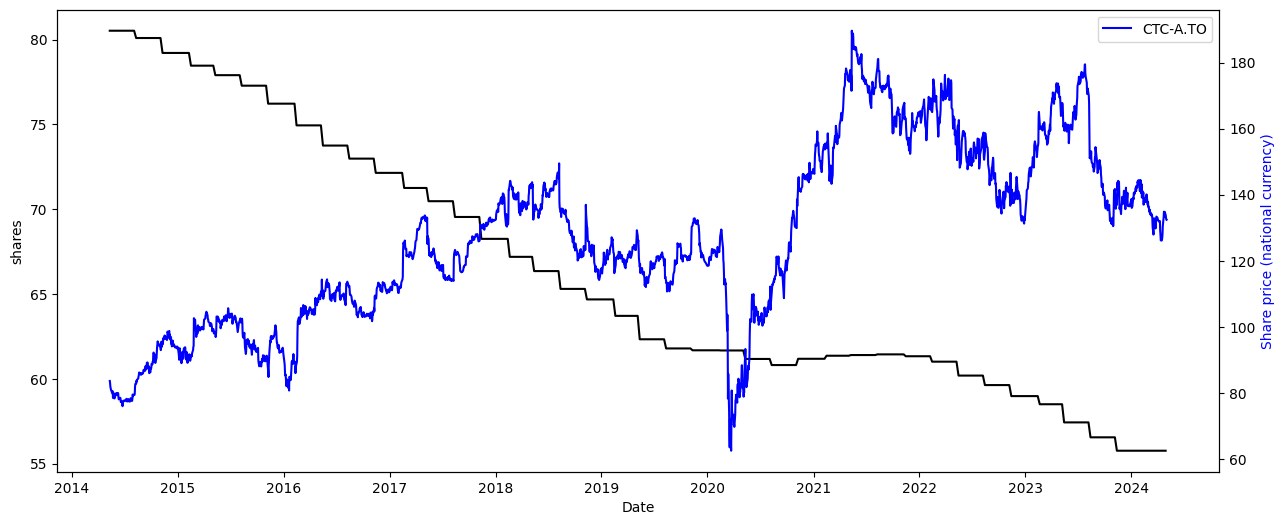

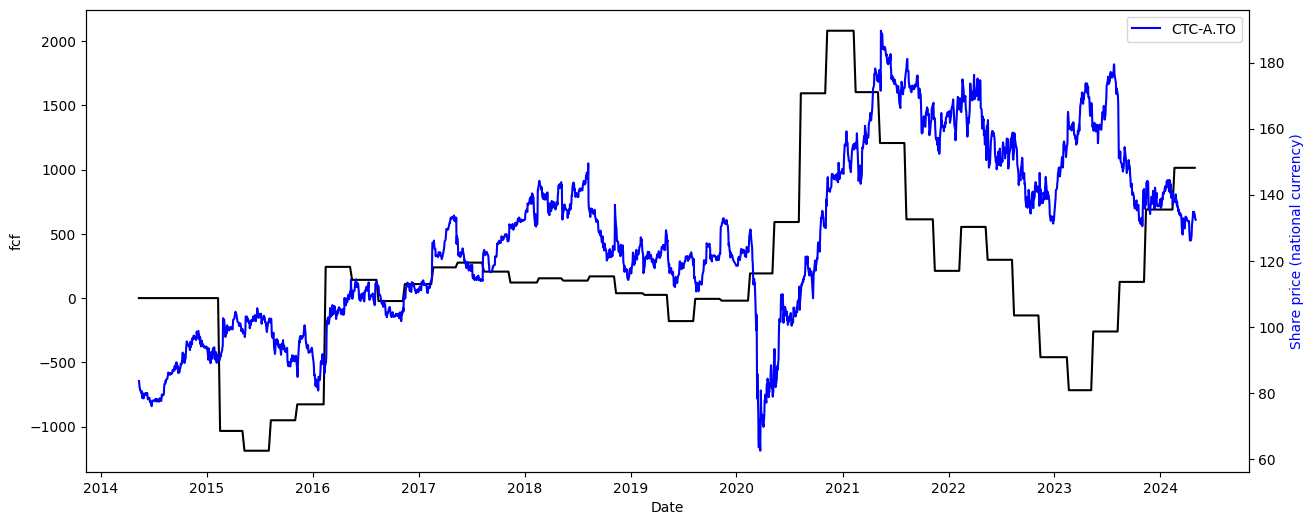

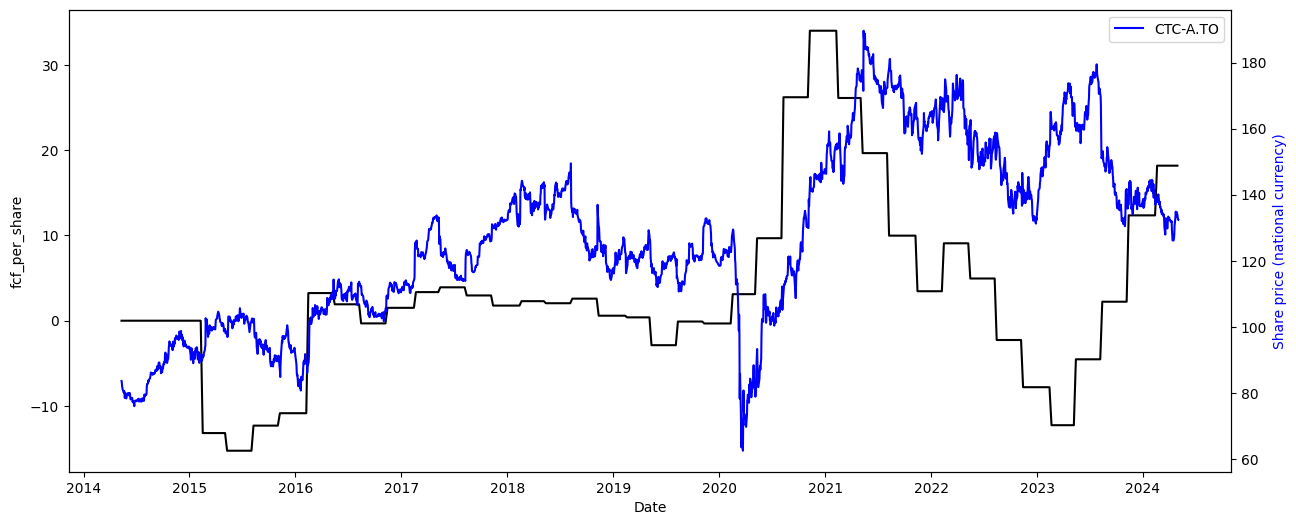

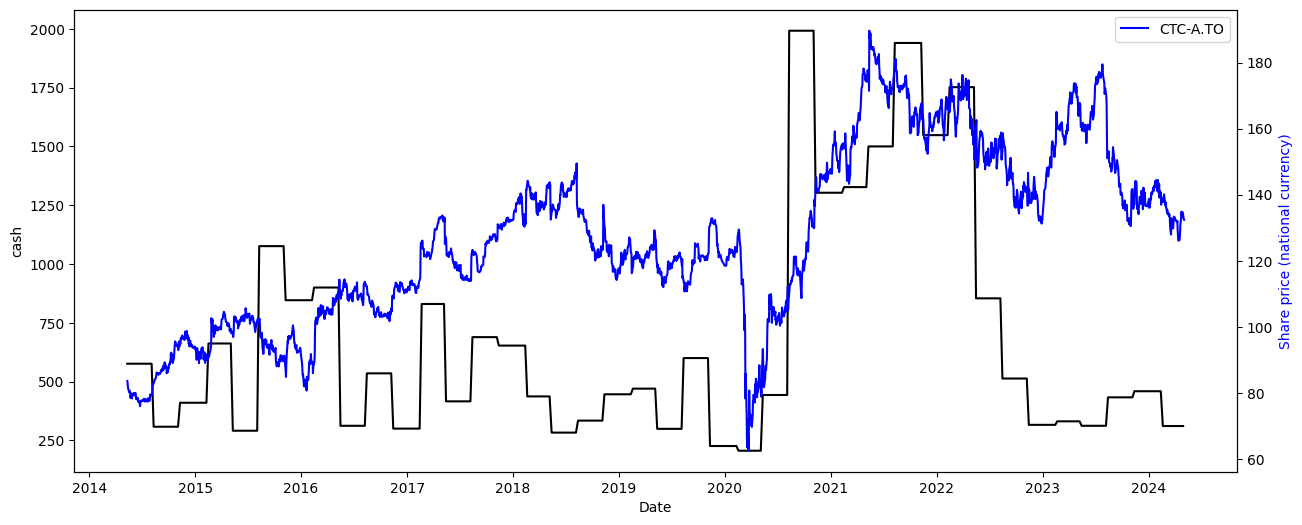

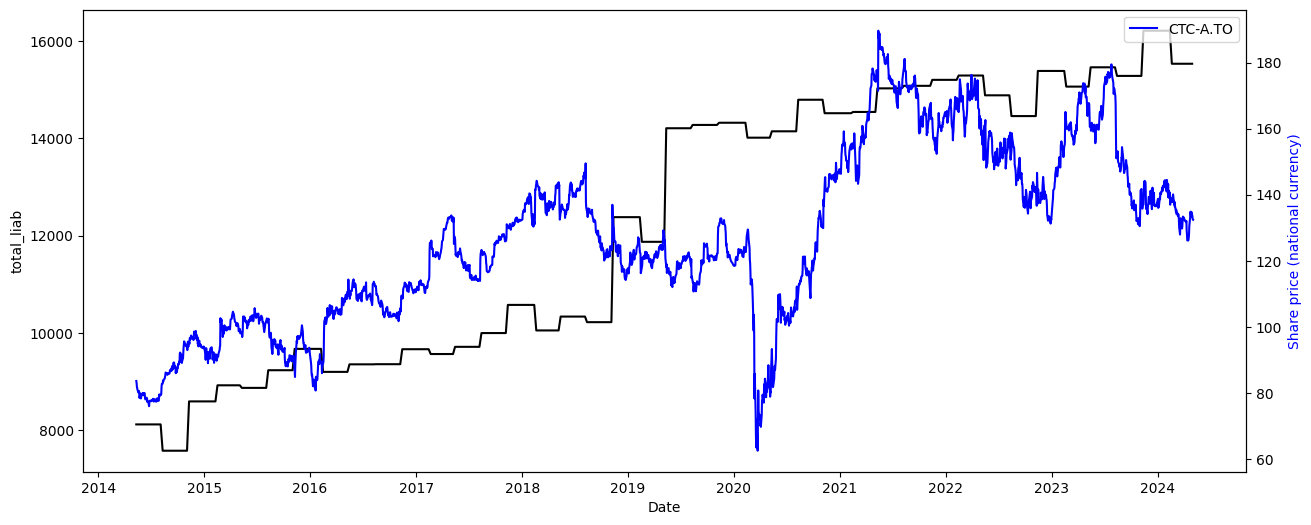

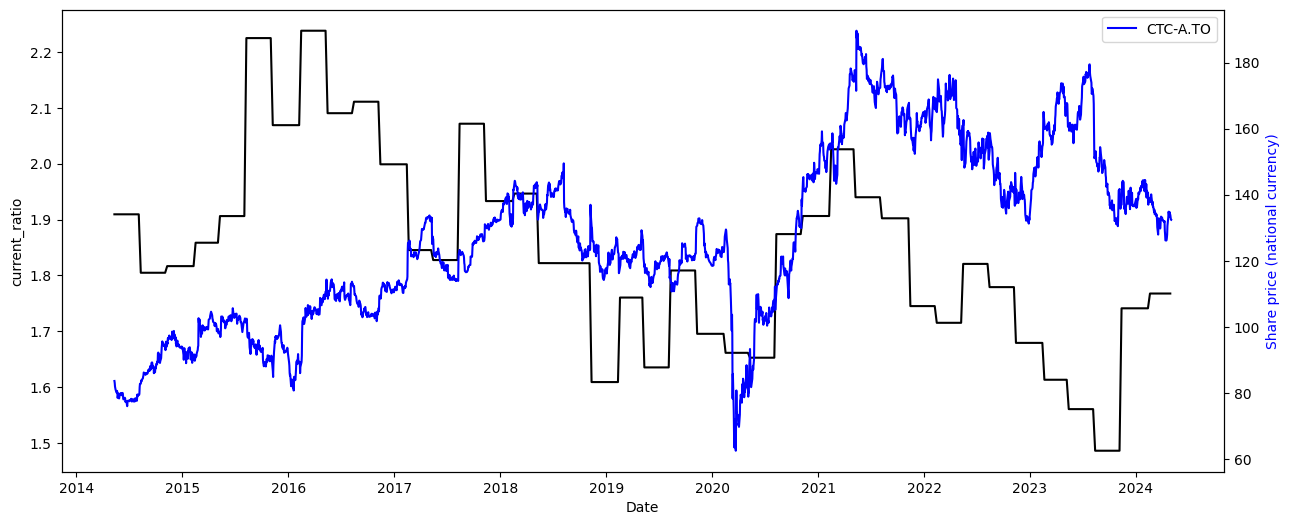

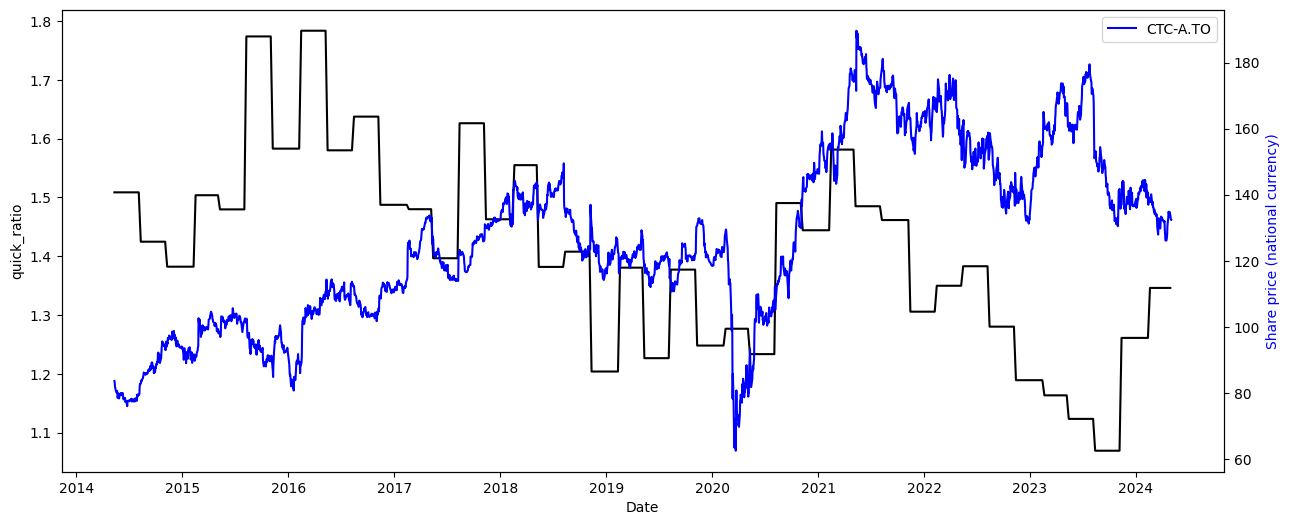

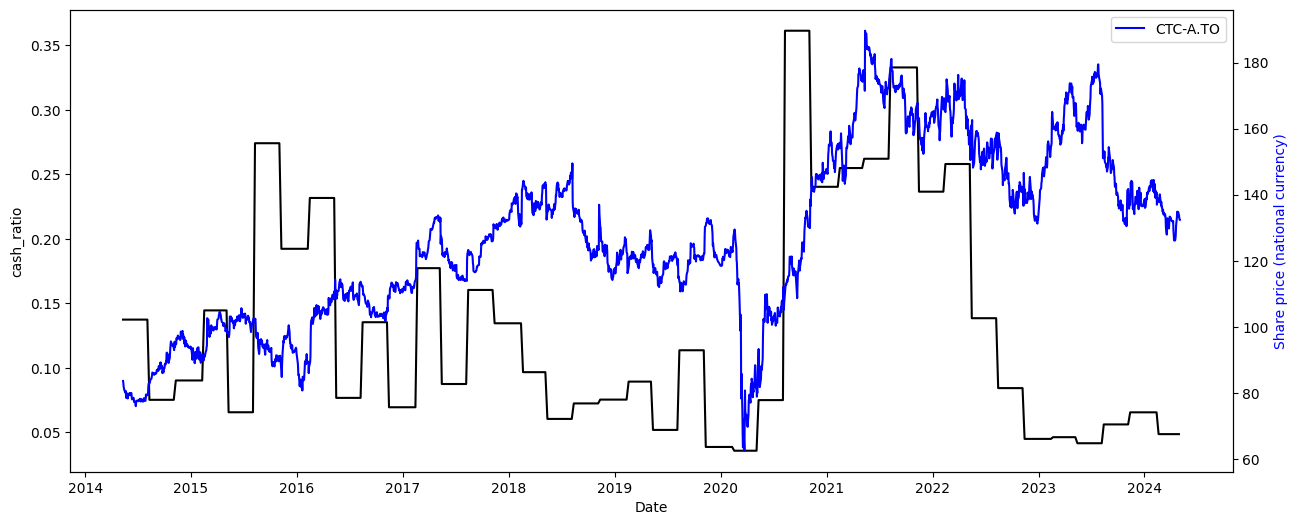

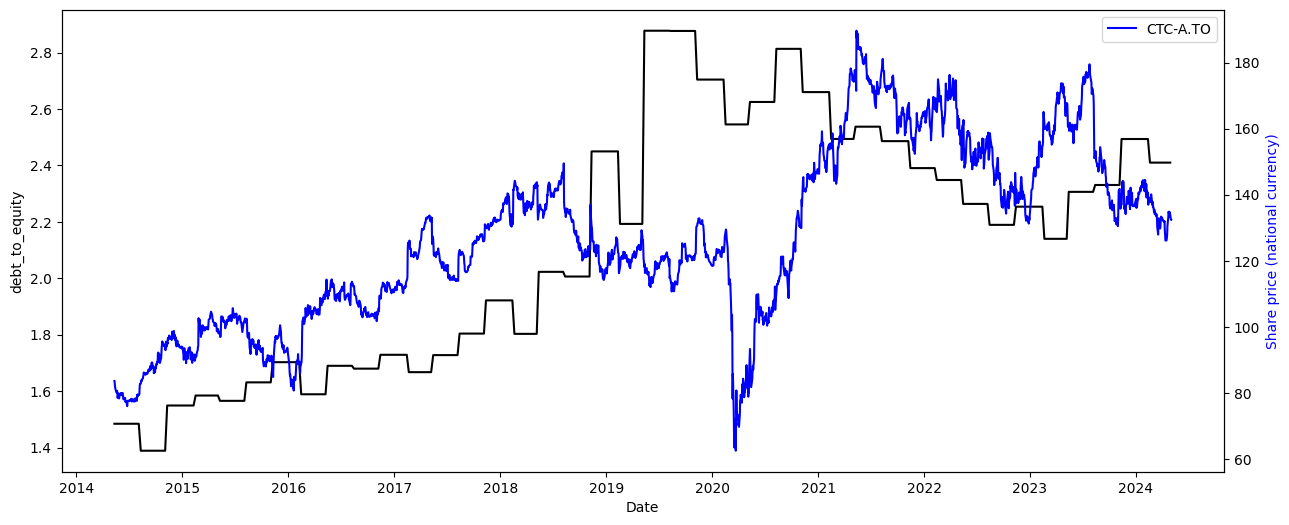

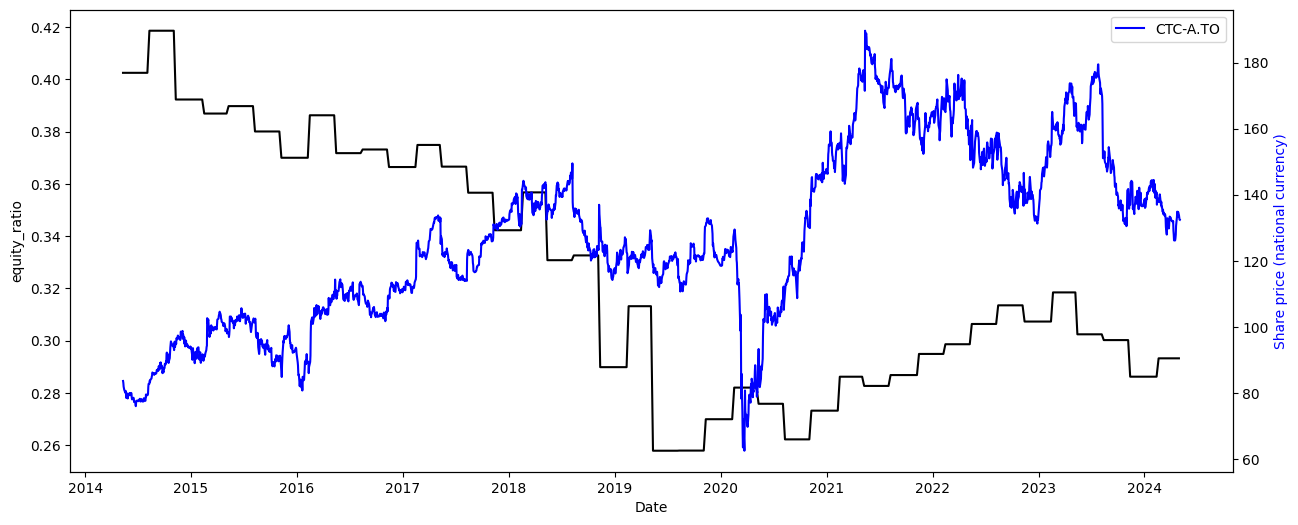

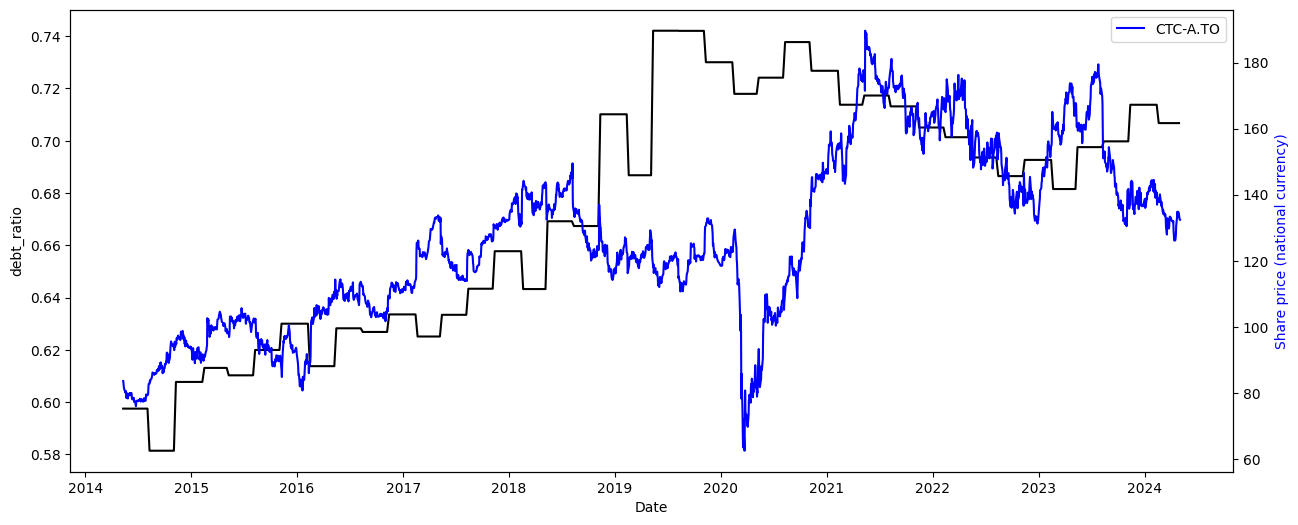

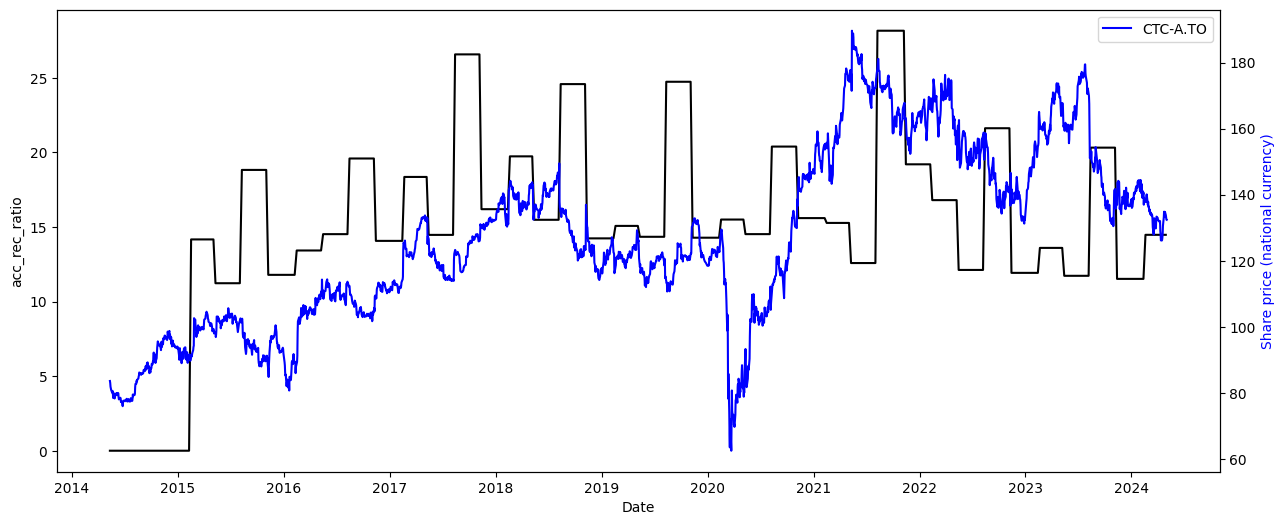

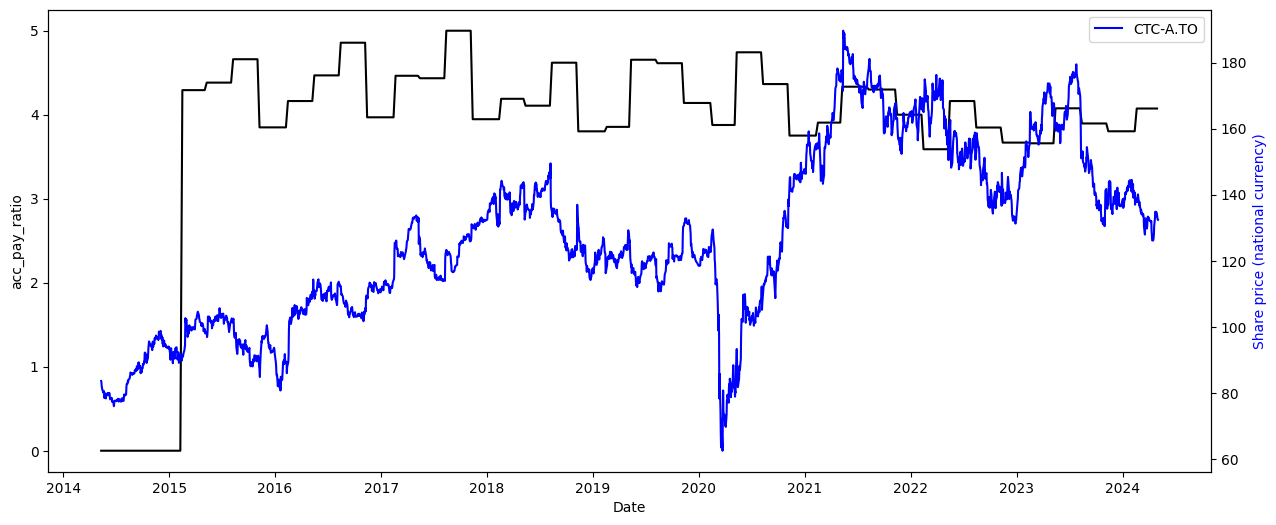

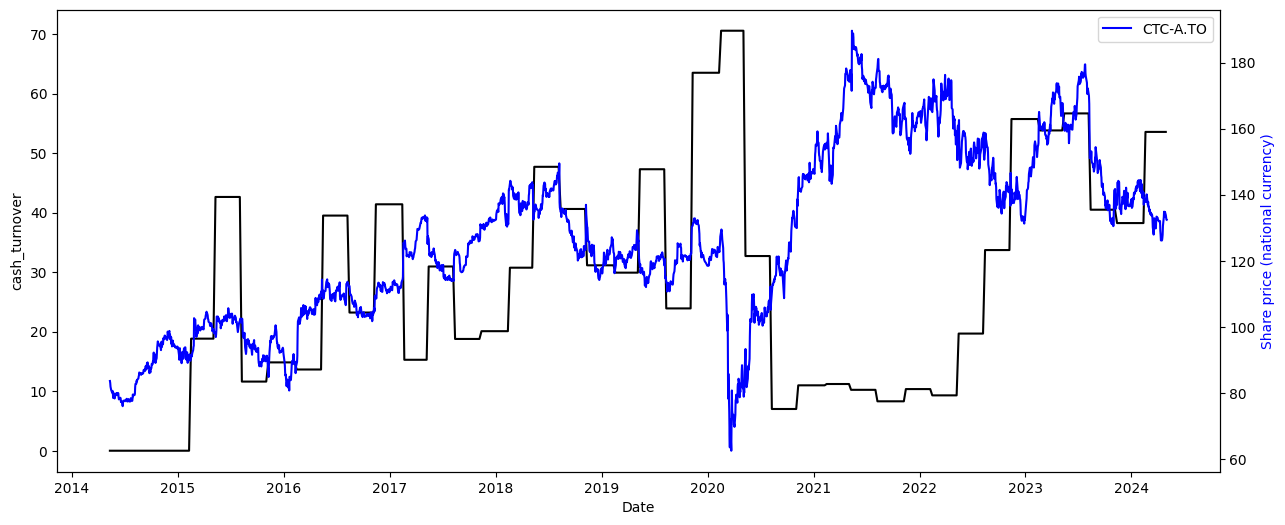

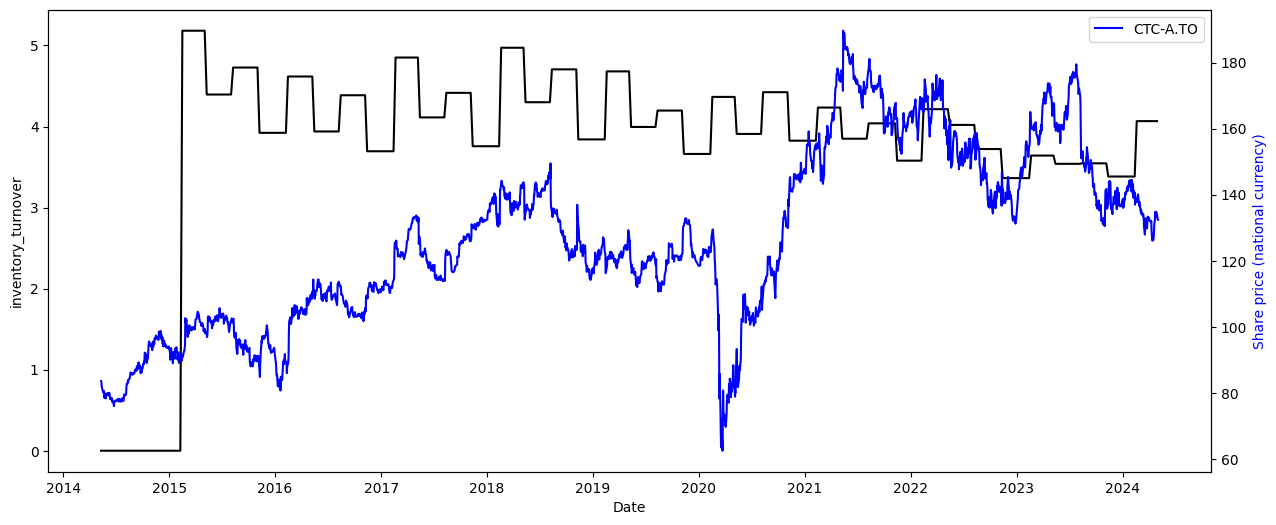

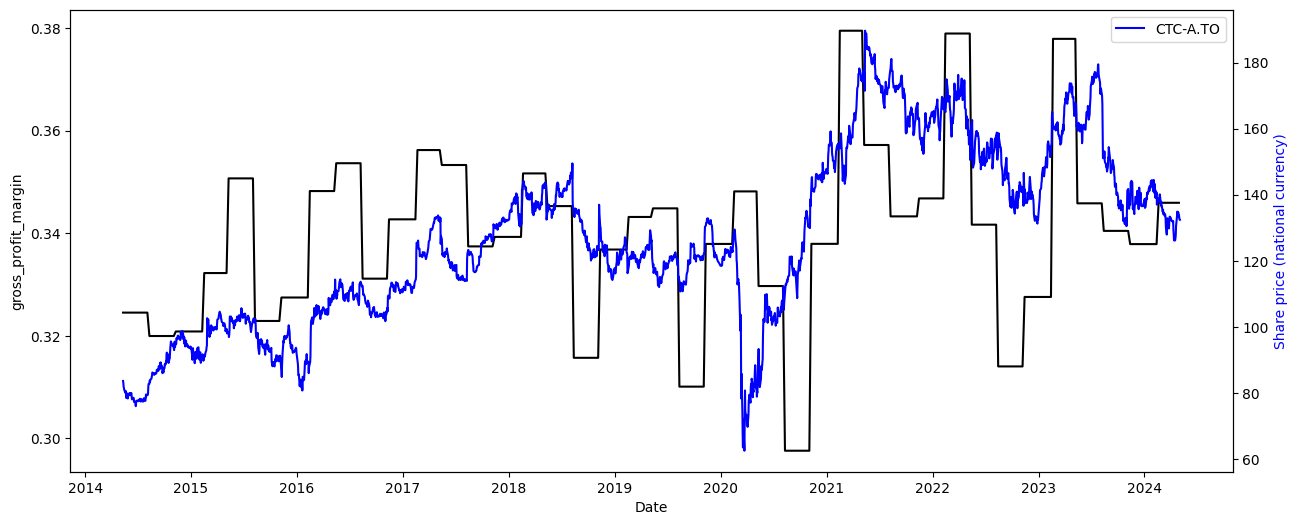

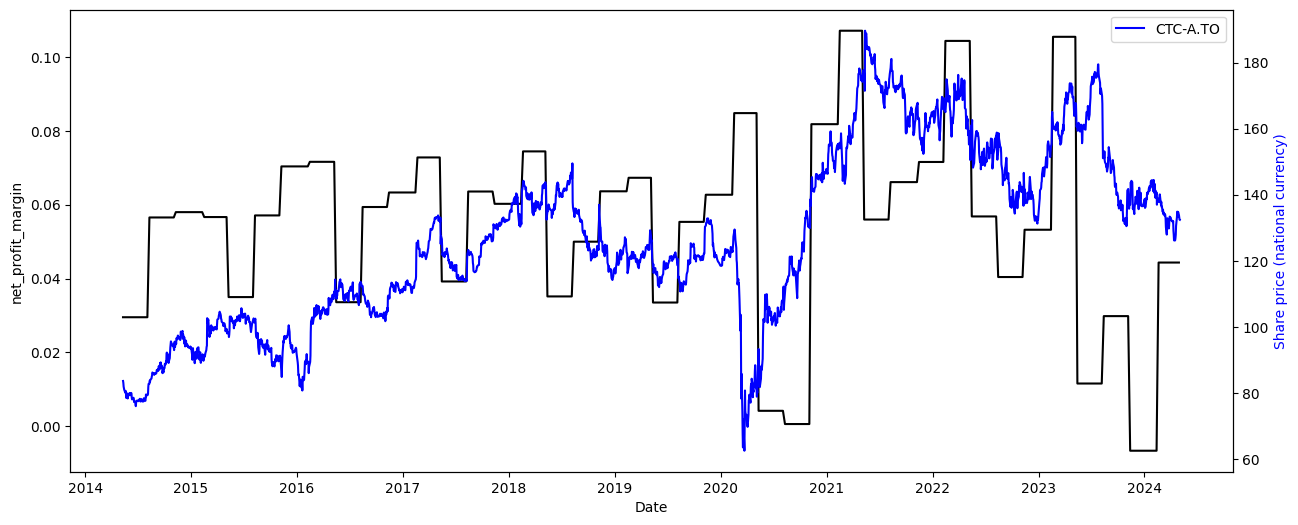

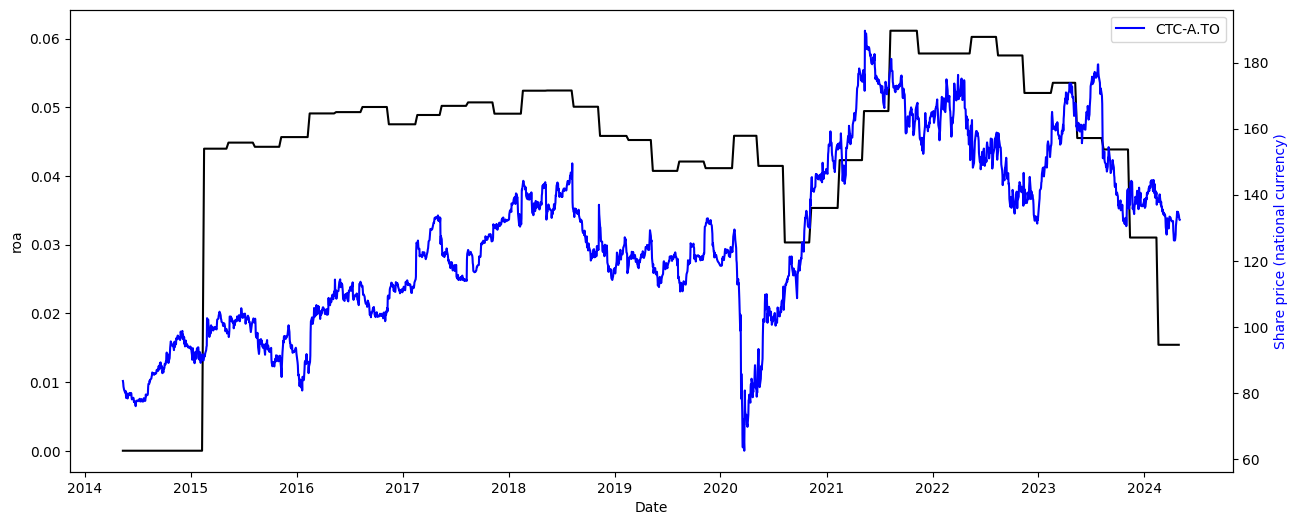

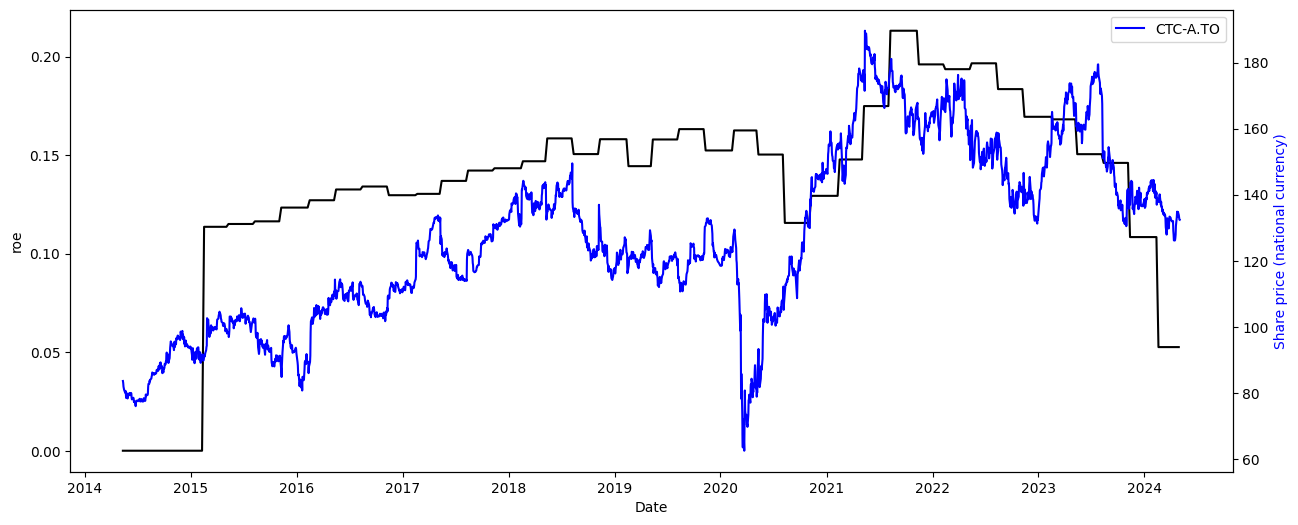

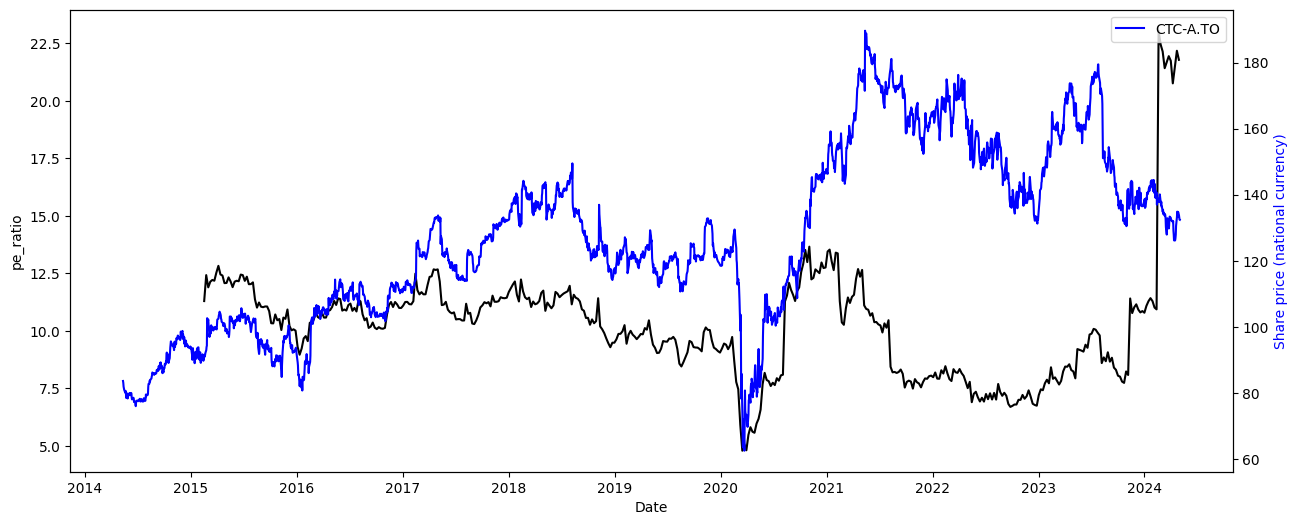

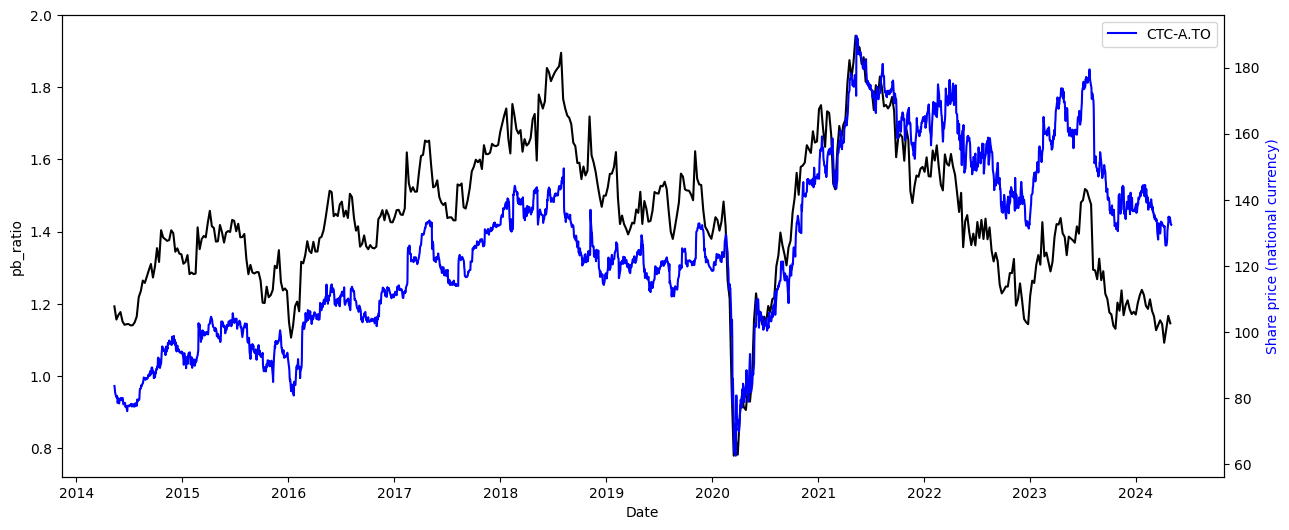

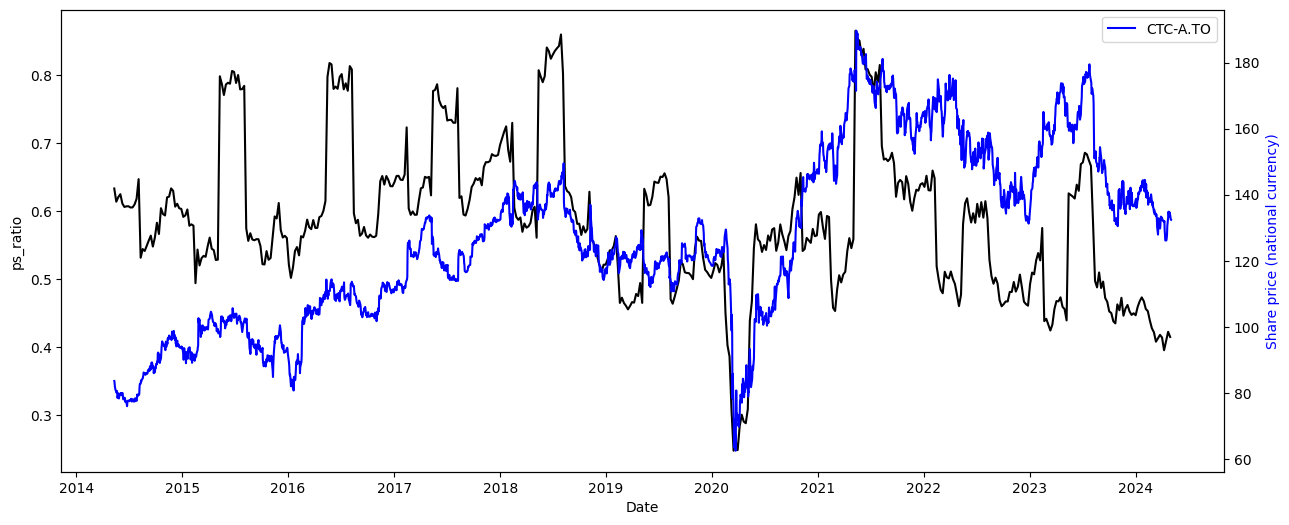

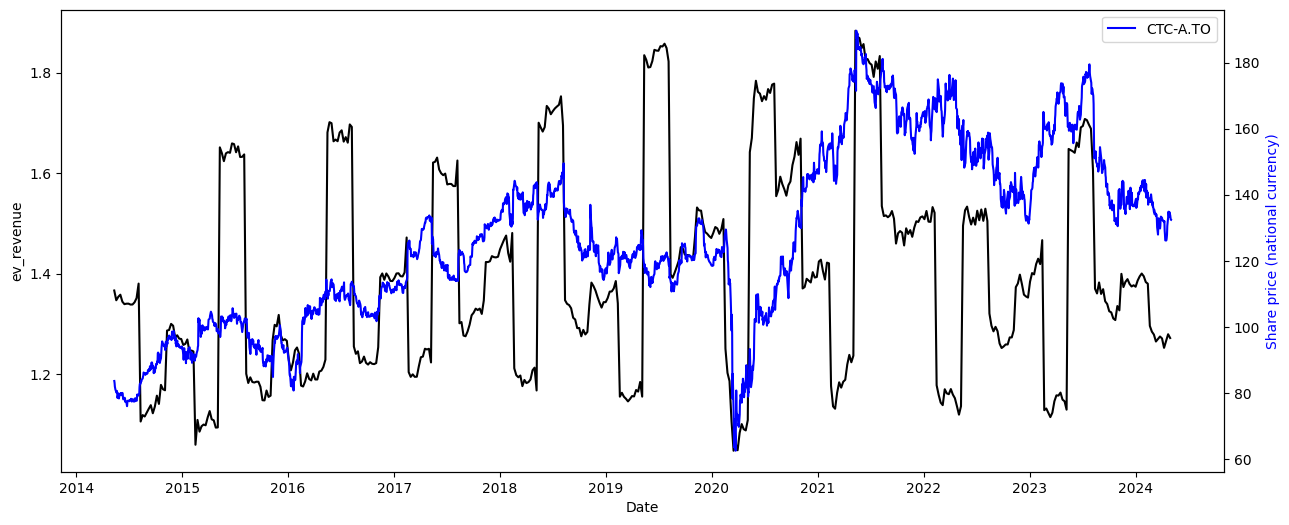

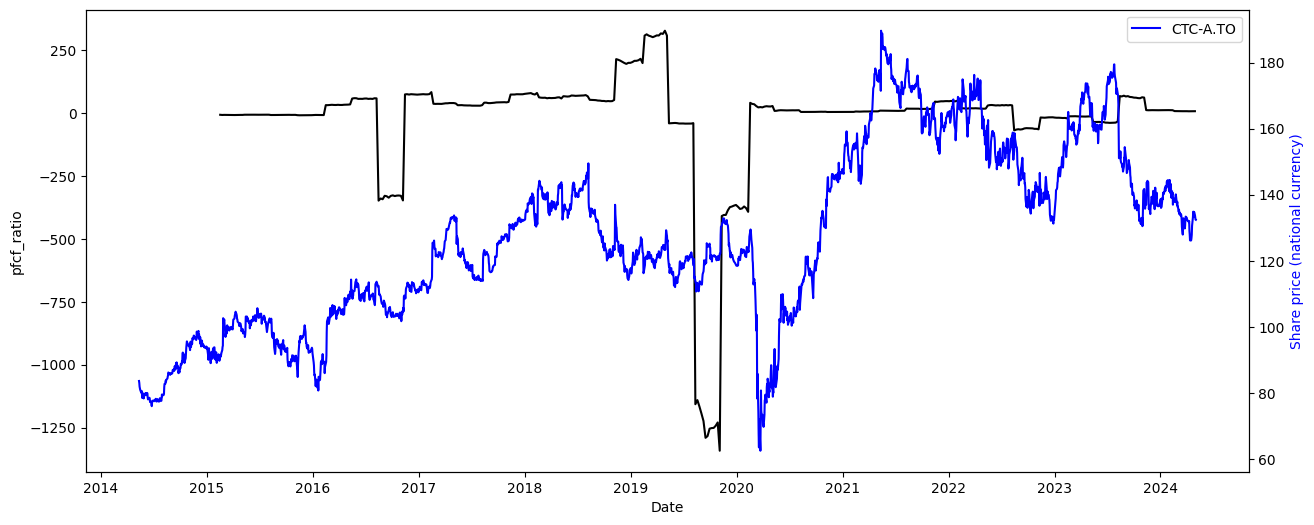

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

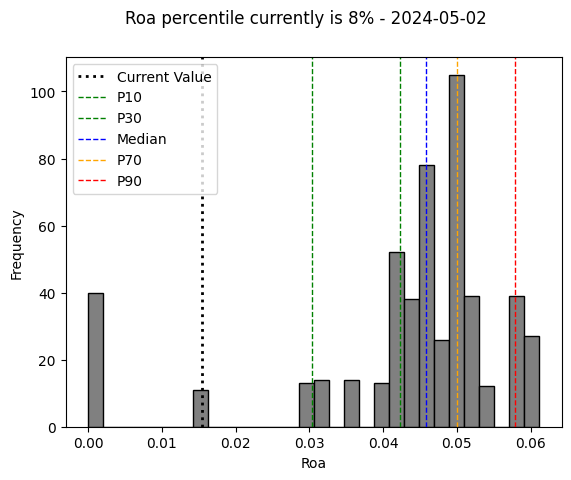

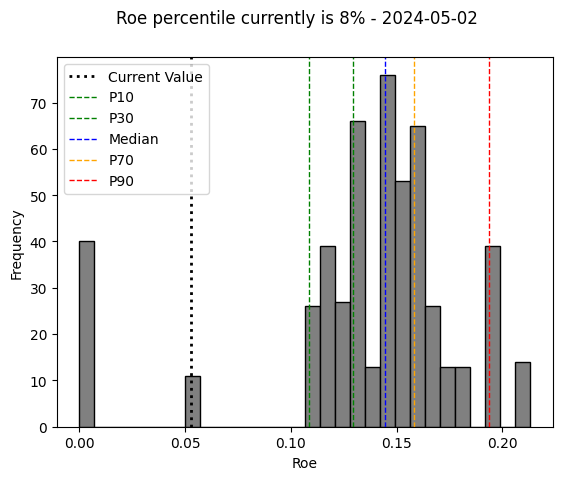

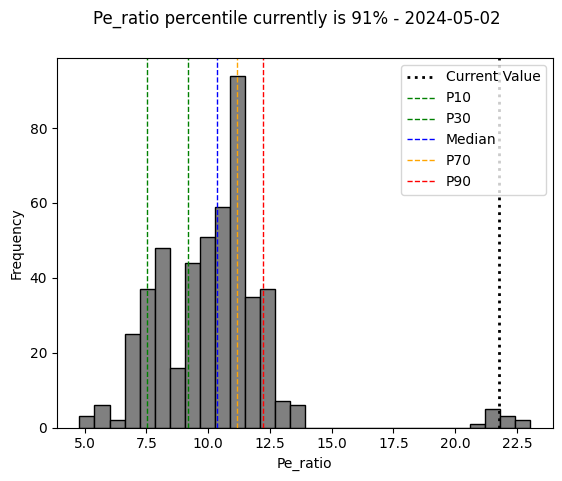

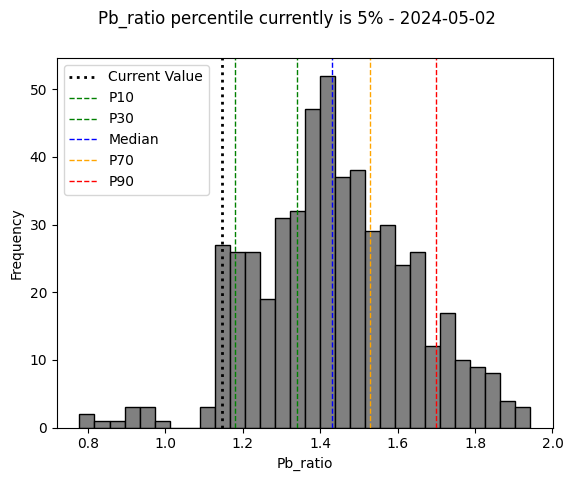

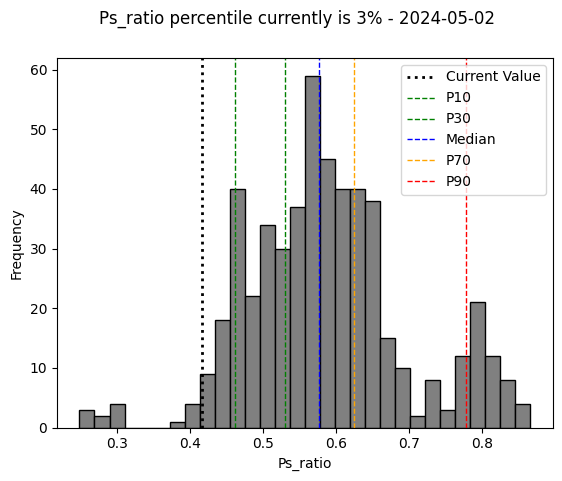

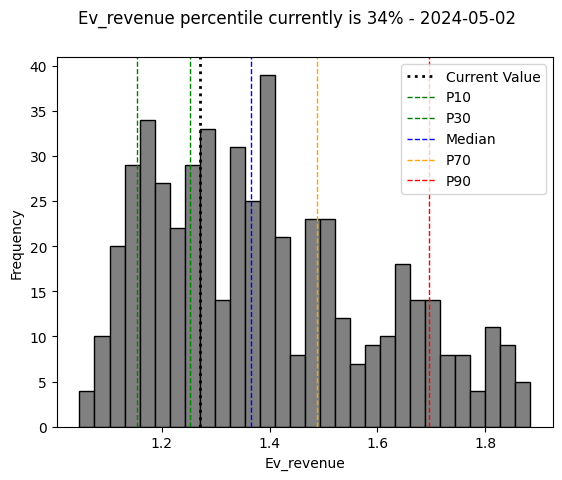

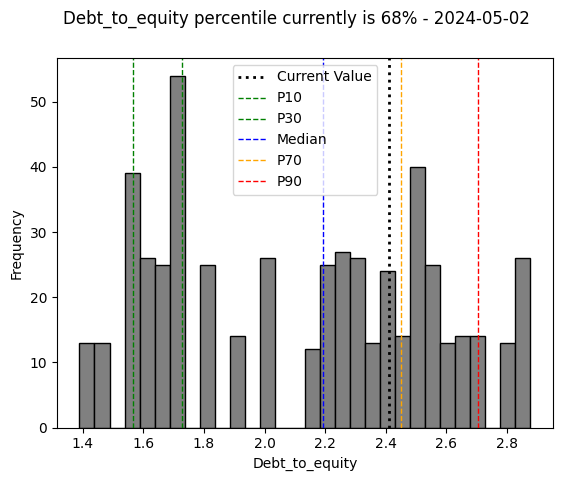

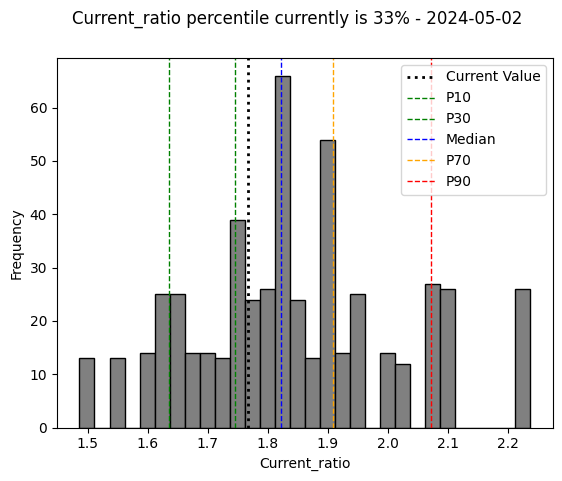

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.933990,-0.665717,0.372718,0.136888,0.141940,0.206598,0.046128
roe,0.933990,1.000000,-0.790819,0.375905,0.019601,0.248580,0.521387,-0.173096
pe_ratio,-0.665717,-0.790819,1.000000,0.168201,0.178724,-0.020609,-0.196348,0.304787
pb_ratio,0.372718,0.375905,0.168201,1.000000,0.617343,0.314271,0.114077,0.185385
ps_ratio,0.136888,0.019601,0.178724,0.617343,1.000000,0.666413,-0.306104,0.343119
ev_revenue,0.141940,0.248580,-0.020609,0.314271,0.666413,1.000000,0.370185,-0.169937
debt_to_equity,0.206598,0.521387,-0.196348,0.114077,-0.306104,0.370185,1.000000,-0.527246
current_ratio,0.046128,-0.173096,0.304787,0.185385,0.343119,-0.169937,-0.527246,1.000000


11 timestemos have been found!


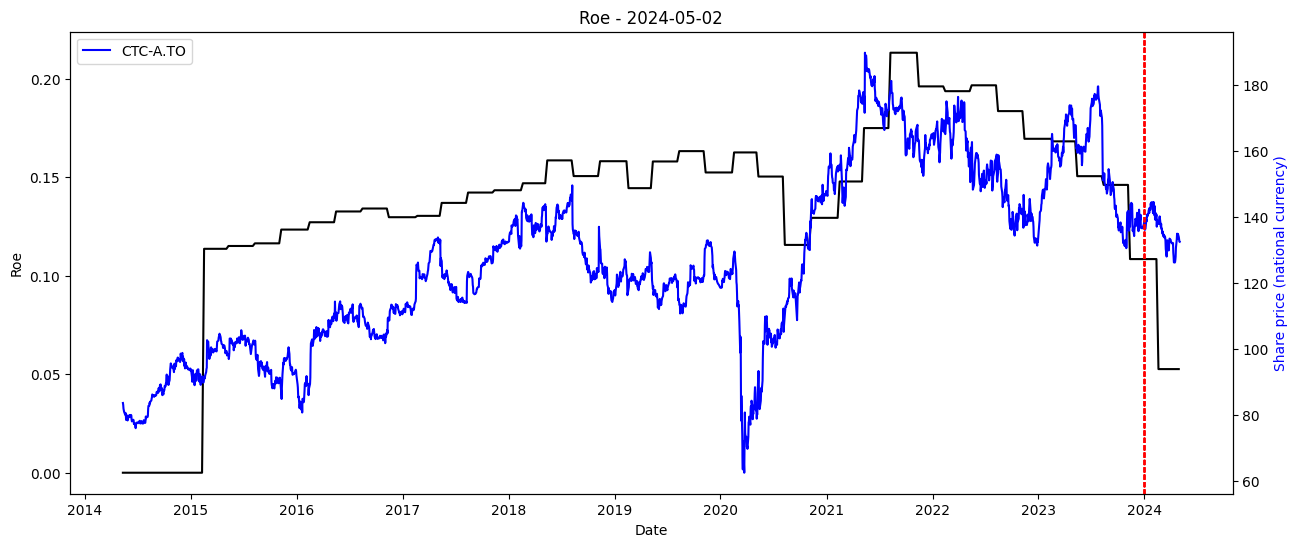

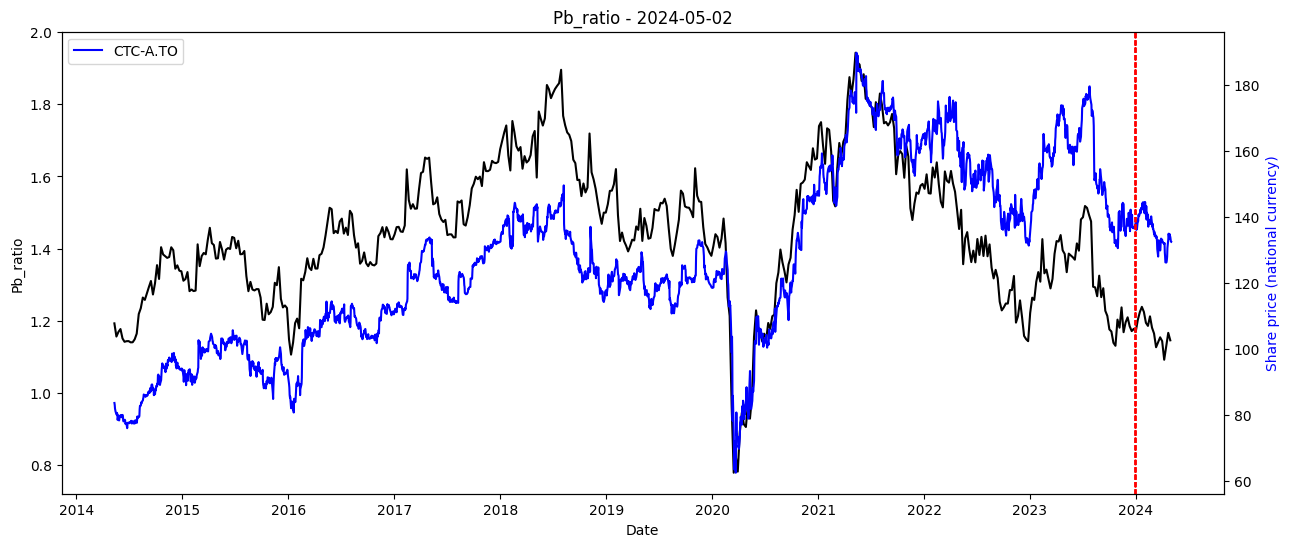

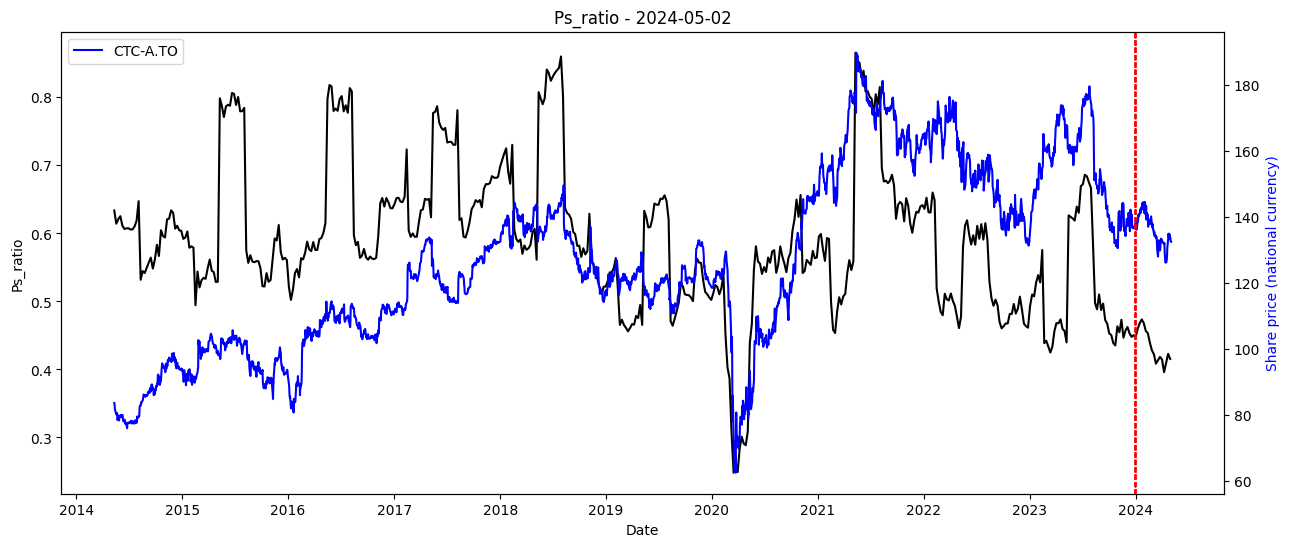

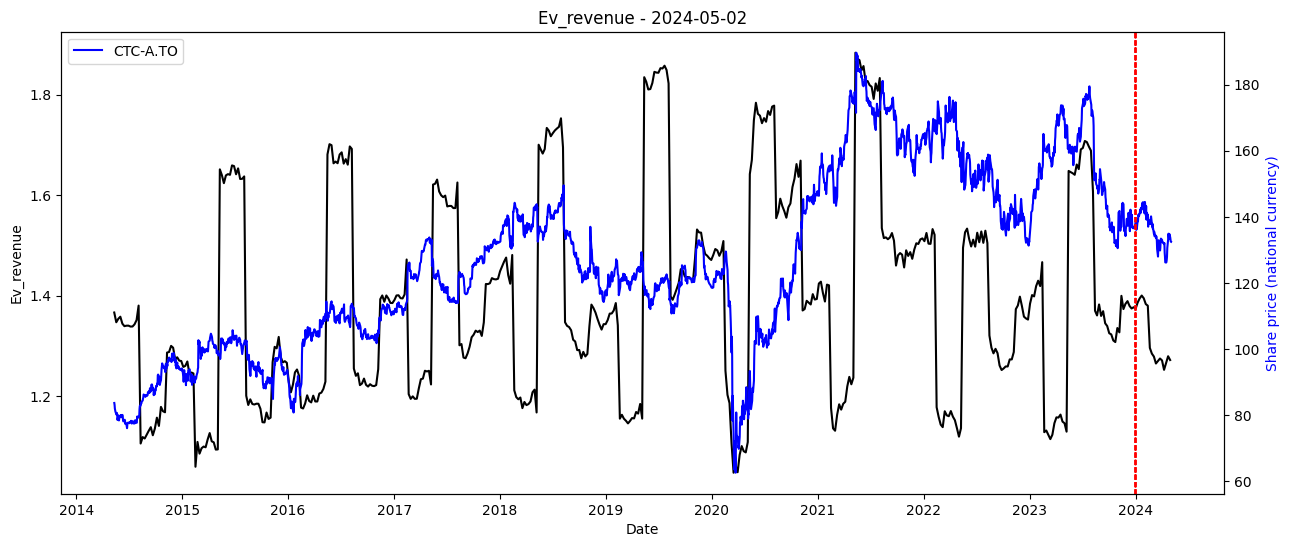

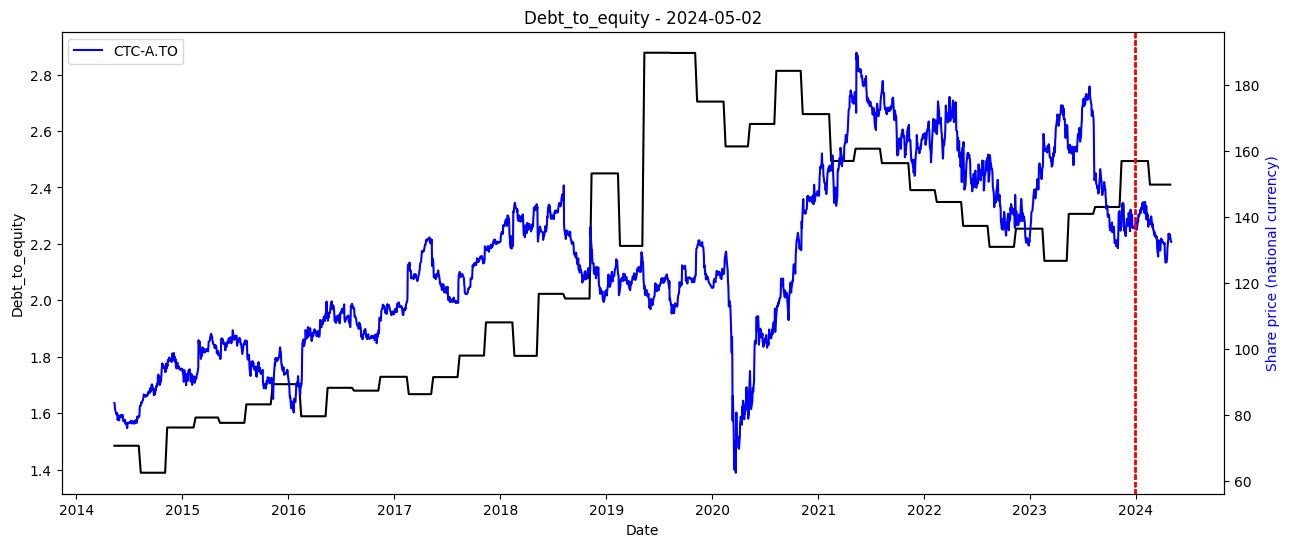

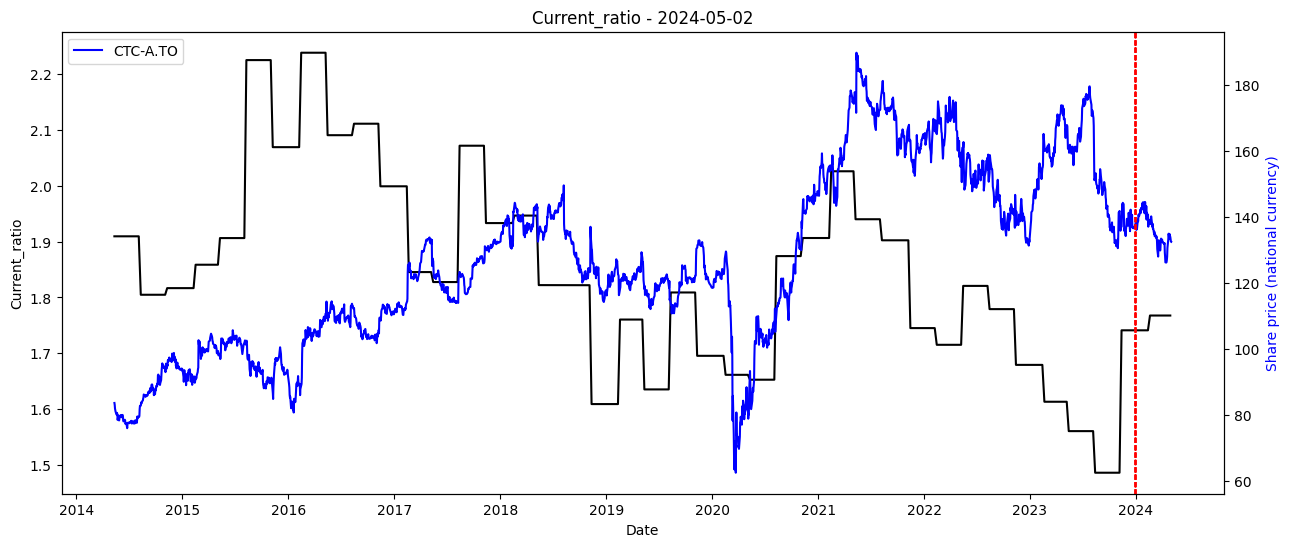

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )